In [1]:
# Импорт библиотек
import sqlite3 
from sqlite3 import Error 
import pandas as pd

**Шаг 1**  
(Балл - 0.2) Необходимо скачать CSV-файл — «final_transactions.csv», создать таблицу transaction_bd со всеми полями, загрузить данные из файла в таблицу и оставить таблицу со структурой:  
(0, 'TX_DATETIME', 'NUMERIC', 0, None, 0) - время транзакций  
(1, 'CUSTOMER_ID', 'INTEGER', 0, None, 0) - клиент  
(2, 'TX_AMOUNT', 'REAL', 0, None, 0) - сумма транзакций  
Комментарий: Можно оставить все 5 полей, но запросы будут выполняться чуть дольше.

In [2]:
# Функция создания Connection с БД
def create_connection(path):
    connection = None
    try:
        connection = sqlite3.connect(path)
        print("Connection to SQLite DB successful")
    except Error as e:
        print(f"The error '{e}' occurred")
    return connection

In [3]:
# Создание Connection с БД. Неяно создает БД, если не существует.
con = create_connection("HW2.db")

Connection to SQLite DB successful


In [4]:
# Функция выполнения запроса к БД. Создание Cursor, выполнение запроса/ошибка, если запрос выполнен, то 
# коммит Connection, закрытие Cursor.
def execute_query(connection, query):
    cursor = connection.cursor()
    try:
        cursor.execute(query)
        connection.commit()
        print("Query executed successfully")
        cursor.close()
    except Error as e:
        print(f"The error '{e}' occurred")

In [5]:
# Запрос на создание таблицы transaction_bd в БД.
create_transaction_table = """
CREATE TABLE IF NOT EXISTS transaction_bd (
  TRANSACTION_ID INTEGER PRIMARY KEY AUTOINCREMENT,
  TX_DATETIME TEXT NOT NULL,
  CUSTOMER_ID INTEGER NOT NULL,
  TERMINAL_ID INTEGER,
  TX_AMOUNT REAL NOT NULL
);
"""

In [6]:
# Исполнение запроса на создание таблицы transaction_bd в БД.
execute_query(con, create_transaction_table)  

Query executed successfully


In [7]:
# Чтение файла csv в датафрейм.
df = pd.read_csv('final_transactions.csv')

In [8]:
# Добавление всех записей с файла final_transactions.csv в таблицу transaction_bd
df.to_sql('transaction_bd', con, if_exists='append', index=False)

In [9]:
# Информация о датафрейме с файла final_transactions.csv. Кол-во записей, кол-во ненулевых значений, кол-во колонок (полей).
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   TRANSACTION_ID  1048575 non-null  int64  
 1   TX_DATETIME     1048575 non-null  object 
 2   CUSTOMER_ID     1048575 non-null  int64  
 3   TERMINAL_ID     1048575 non-null  int64  
 4   TX_AMOUNT       1048575 non-null  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 40.0+ MB


In [10]:
# Кол-во уникальных клиентов в датафрейме/таблице.
df['CUSTOMER_ID'].nunique()

4986

**Шаг 2**  
(Балл - 0.1 за каждый пункт) Написать следующие запросы к таблице transaction_bd:  
**2A.** Вывести всех клиентов, у которых сумма транзакций больше 700000 за весь период (сортируя клиентов по возрастанию);


In [11]:
# Запрос для пункта 2А
query_a = """
SELECT CUSTOMER_ID, SUM(TX_AMOUNT)
FROM transaction_bd
GROUP BY CUSTOMER_ID
HAVING SUM(TX_AMOUNT) > 700000
ORDER BY CUSTOMER_ID;
"""

In [12]:
# Выполнение запроса для пункта 2А и запись в датафрейм.
df_a = pd.read_sql_query(query_a, con)
df_a

,CUSTOMER_ID,SUM(TX_AMOUNT)
0,389,753411.90
1,2249,707478.64
2,2891,786115.87
3,3116,721980.69
4,4163,765153.63


**2B.** Вывести всех клиентов, у которых сумма транзакций больше 200000 за период 01.01.2023 - 13.01.2023 (сортируя клиентов по возрастанию);

In [13]:
# Запрос для пункта 2B
query_b = """
SELECT CUSTOMER_ID, SUM(TX_AMOUNT)
FROM transaction_bd
WHERE strftime('%Y-%m-%d', TX_DATETIME) BETWEEN '2023-01-01' AND '2023-01-13'
GROUP BY CUSTOMER_ID
HAVING SUM(TX_AMOUNT) > 200000
ORDER BY CUSTOMER_ID;
"""

In [14]:
# Выполнение запроса для пункта 2B и запись в датафрейм.
df_b = pd.read_sql_query(query_b, con)
df_b

,CUSTOMER_ID,SUM(TX_AMOUNT)
0,1918,241299.96
1,3406,207733.48
2,3833,269107.40
3,4252,220650.36


**2C.** Вывести тех клиентов, у которых id начинается с 4 и количество транзакций за весь период более 444;

In [15]:
# Запрос для пункта 2C
query_c = """
SELECT CUSTOMER_ID, COUNT(TX_AMOUNT)
FROM transaction_bd
WHERE CUSTOMER_ID LIKE '4%'
GROUP BY CUSTOMER_ID
HAVING COUNT(TX_AMOUNT) > 444;
"""

In [16]:
# Выполнение запроса для пункта 2C и запись в датафрейм.
df_c = pd.read_sql_query(query_c, con)
df_c

,CUSTOMER_ID,COUNT(TX_AMOUNT)
0,4231,451
1,4539,445
2,4661,449


**2D.** Создать флаг доходности клиентов по логике:  
1. Если сумма транзакций не более 50000, тогда вывести 'низкая доходность';  
2. Если сумма транзакций больше 50000 и не более 100000 тогда вывести 'средняя доходность';  
3. Если сумма транзакций больше 100000 тогда вывести 'высокая доходность'.

In [17]:
# Запрос для пункта 2D
query_d = """
SELECT CUSTOMER_ID, SUM(TX_AMOUNT),
CASE
    WHEN SUM(TX_AMOUNT) <= 50000 THEN 'низкая доходность'
    WHEN SUM(TX_AMOUNT) > 50000 AND SUM(TX_AMOUNT) <= 100000 THEN 'средняя доходность'
    WHEN SUM(TX_AMOUNT) > 100000 THEN 'высокая доходность'
    ELSE ''
END AS PROFIT_FLAG
FROM transaction_bd
GROUP BY CUSTOMER_ID
;
"""

In [18]:
# Выполнение запроса для пункта 2D и запись в датафрейм.
df_d = pd.read_sql_query(query_d, con)
df_d

,CUSTOMER_ID,SUM(TX_AMOUNT),PROFIT_FLAG
0,0,119568.47,высокая доходность
1,1,323510.82,высокая доходность
2,2,162541.90,высокая доходность
3,3,2406.56,низкая доходность
4,4,300589.33,высокая доходность
...,...,...,...
4981,4995,149962.31,высокая доходность
4982,4996,27135.67,низкая доходность
4983,4997,131288.62,высокая доходность
4984,4998,337988.39,высокая доходность


**2E.** Посмотреть количество клиентов с каждым видом доходности (из пункта 2.d);

In [19]:
# Запрос для пункта 2E
query_e = """
SELECT PROFIT_FLAG, COUNT(CUSTOMER_ID)
FROM (SELECT CUSTOMER_ID, SUM(TX_AMOUNT),
    CASE
        WHEN SUM(TX_AMOUNT) <= 50000 THEN 'низкая доходность'
        WHEN SUM(TX_AMOUNT) > 50000 AND SUM(TX_AMOUNT) <= 100000 THEN 'средняя доходность'
        WHEN SUM(TX_AMOUNT) > 100000 THEN 'высокая доходность'
        ELSE ''
    END AS PROFIT_FLAG
    FROM transaction_bd
    GROUP BY CUSTOMER_ID)
GROUP BY PROFIT_FLAG;
"""

In [20]:
# Выполнение запроса для пункта 2E и запись в датафрейм.
df_e = pd.read_sql_query(query_e, con)
df_e

,PROFIT_FLAG,COUNT(CUSTOMER_ID)
0,высокая доходность,2167
1,низкая доходность,1812
2,средняя доходность,1007


**2F.** Вывести сумму транзакций за каждый день (сортируя дни по возрастанию).

In [21]:
# Запрос для пункта 2F
query_f = """
SELECT strftime('%Y-%m-%d', TX_DATETIME) AS DATE, SUM(TX_AMOUNT)
FROM transaction_bd
GROUP BY strftime('%Y-%m-%d', TX_DATETIME)
ORDER BY DATE;
"""

In [22]:
# Выполнение запроса для пункта 2F и запись в датафрейм.
df_f = pd.read_sql_query(query_f, con)
df_f

,DATE,SUM(TX_AMOUNT)
0,2023-01-01,4827656.26
1,2023-01-02,4862551.41
2,2023-01-03,5058973.71
3,2023-01-04,4938142.47
4,2023-01-05,5002954.23
...,...,...
105,2023-04-16,5299386.81
106,2023-04-17,5100973.31
107,2023-04-18,5233557.39
108,2023-04-19,5194846.44


**Шаг 3**  
(Балл - 0.2) Подготовить дашборд с помощью Dash по пункту 2.f, включив туда графики bar и histogram;  
вставить в конце ноутбука скрин графиков из дашборда.

In [23]:
#!pip install dash

In [24]:
#!pip install jupyter-dash

In [25]:
# Импорт библиотек
from dash import Dash
import dash_core_components as dcc
import dash_html_components as html
import plotly.express as px

In [26]:
# Создание Dash, графиков bar и histogram, отображение локально.
app = Dash()

fig1 = px.bar(df_f, x="DATE", y="SUM(TX_AMOUNT)", title = 'Сумма транзакций за каждый день с 01.01.2023 по 20.04.2023')

fig2 = px.histogram(df_f, x="SUM(TX_AMOUNT)", nbins=5, title = \
                    'Частотное распределение суммы транзакций по дням с 01.01.2023 по 20.04.2023')

app.layout = html.Div(children=[
    html.H1(children='Данные по суммам транзакций с 01.01.2023 по 20.04.2023', style={'textAlign':'center'}),

    dcc.Graph(
        id='bar_graph',
        figure=fig1
    ),
     dcc.Graph(
        id='hist_graph',
        figure=fig2
    )
])

app.run_server()

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [31/Mar/2023 00:49:03] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [31/Mar/2023 00:49:03] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [31/Mar/2023 00:49:03] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [31/Mar/2023 00:49:03] "GET /_dash-component-suites/dash_core_components/async-graph.js HTTP/1.1" 200 -
127.0.0.1 - - [31/Mar/2023 00:49:04] "GET /_dash-component-suites/dash_core_components/async-plotlyjs.js HTTP/1.1" 200 -


Изображение графиков
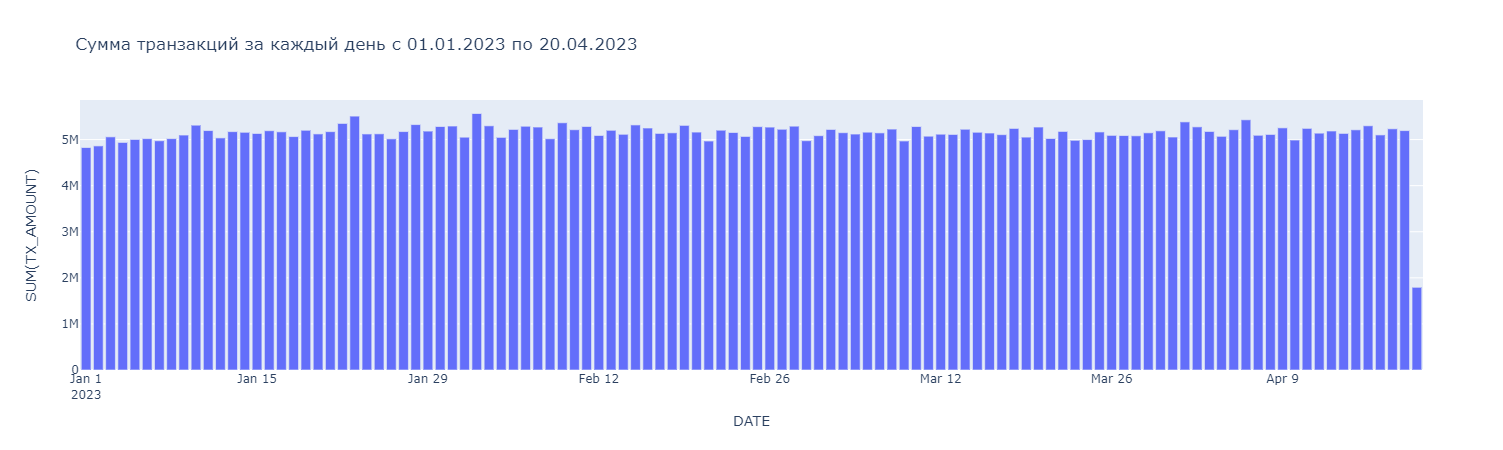  



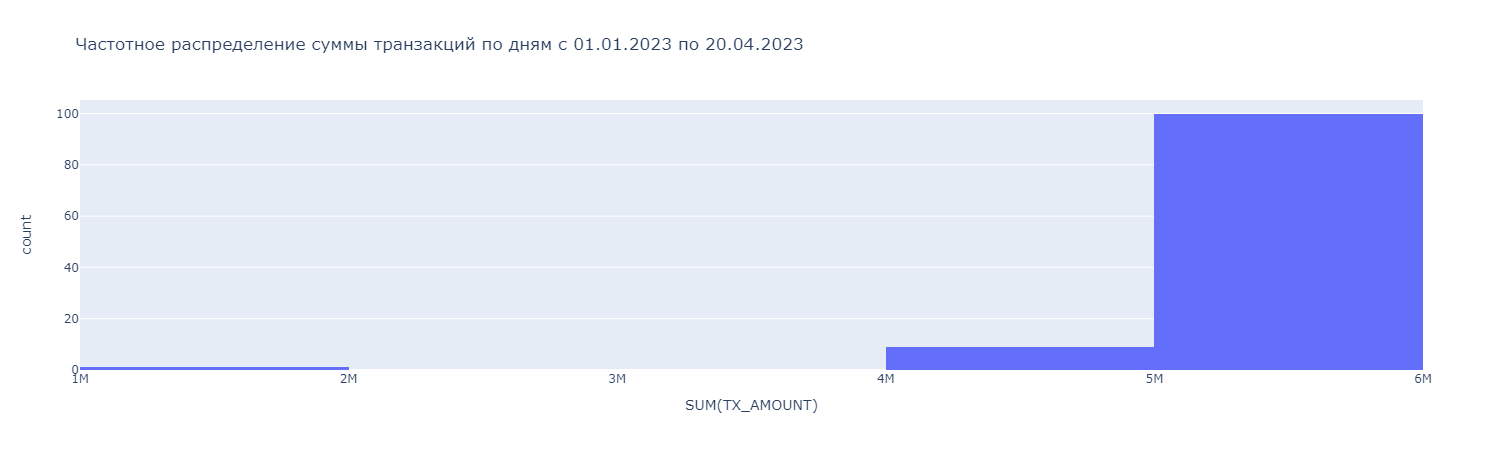

In [27]:
# Закрытие Connection с БД.
con.close()